In [1]:
%pylab inline
import pandas as pd
from scipy.spatial import cKDTree

Populating the interactive namespace from numpy and matplotlib


In [138]:
# old code
def extract_fiducials(df, blobs, radius, diagnostics=False):
    """Do the actual filtering
    
    We're doing it sequentially because we may run out of memory.
    If initial DataFrame is 18 GB (1 GB per column) and we have 200 """
    fiducials_dfs = [df[np.sqrt((df.x0 - x) ** 2 + (df.y0 - y) ** 2) < radius]
                     for y, x in blobs]
    return fiducials_dfs

In [125]:
data = pd.DataFrame(rand(1000000, 3)*100, columns=[c + "0" for c in "xyz"])
test_points = pd.DataFrame(rand(1000, 2)*100, columns=[c + "0" for c in "xy"])

In [77]:
data.head()

,x0,y0,z0
0,66.603890,70.022372,65.922838
1,63.498939,92.099948,69.462033
2,2.459055,35.651718,10.962859
3,81.724244,42.629706,50.450649
4,82.121892,6.642010,19.540001


{0: {'x0': 66.60388962803867,
  'y0': 70.02237241495686,
  'z0': 65.92283797733938},
 1: {'x0': 63.49893871121613,
  'y0': 92.09994847053868,
  'z0': 69.46203271824403},
 2: {'x0': 2.459054622111456,
  'y0': 35.651717891860436,
  'z0': 10.962858670049947},
 3: {'x0': 81.72424389551612,
  'y0': 42.62970629015187,
  'z0': 50.45064898223244},
 4: {'x0': 82.12189185788644,
  'y0': 6.642009718684417,
  'z0': 19.540000781028688}}

In [116]:
data.index = np.arange(len(data))

In [117]:
data.index

Int64Index([   0,    1,    2,    3,    4,    5,    6,    7,    8,    9,
            ...
            9990, 9991, 9992, 9993, 9994, 9995, 9996, 9997, 9998, 9999],
           dtype='int64', length=10000)

In [ ]:
# new code
def extract_fiducials2(df, blobs, radius):
    """Extract fiducials from point cloud"""
    # build tree
    tree = cKDTree(df[["y0", "x0"]].values)
    # extract matches
    matches = tree.query_ball_point(blobs, radius)
    return [df.iloc[m] for m in matches]

In [80]:
%load_ext line_profiler

The line_profiler extension is already loaded. To reload it, use:
  %reload_ext line_profiler


In [ ]:
data.iat[]

In [126]:
%lprun -f extract_fiducials2 extract_fiducials2(data, test_points[["y0", "x0"]].values, 0.25)

Timer unit: 1e-06 s

Total time: 1.63577 s
File: <ipython-input-123-db68e7be6539>
Function: extract_fiducials2 at line 1

Line #      Hits         Time  Per Hit   % Time  Line Contents
     1                                           def extract_fiducials2(df, blobs, radius):
     2         1    1254103.0 1254103.0     76.7      tree = cKDTree(df[["y0", "x0"]].values)
     3         1      10296.0  10296.0      0.6      matches = tree.query_ball_point(blobs, radius)
     4         1     371368.0 371368.0     22.7      return [df.iloc[m] for m in matches]

In [127]:
%lprun -f extract_fiducials extract_fiducials(data, test_points[["y0", "x0"]].values, 0.25)

Timer unit: 1e-06 s

Total time: 42.5768 s
File: <ipython-input-21-8d69ef4928c2>
Function: extract_fiducials at line 2

Line #      Hits         Time  Per Hit   % Time  Line Contents
     2                                           def extract_fiducials(df, blobs, radius, diagnostics=False):
     3                                               """Do the actual filtering
     4                                               
     5                                               We're doing it sequentially because we may run out of memory.
     6                                               If initial DataFrame is 18 GB (1 GB per column) and we have 200 """
     7         1          2.0      2.0      0.0      fiducials_dfs = [df[np.sqrt((df.x0 - x) ** 2 + (df.y0 - y) ** 2) < radius]
     8         1   42576800.0 42576800.0    100.0                       for y, x in blobs]
     9         1          1.0      1.0      0.0      return fiducials_dfs

In [143]:
times1 = []
times2 = []
for num_data in (10000, 100000, 1000000, 10000000):
    nd1 = []
    nd2 = []
    for num_test in (1, 10, 100, 1000):
        nt1 = []
        nt2 = []
        data = pd.DataFrame(rand(num_data, 3) * 100, columns=[c + "0" for c in "xyz"])
        test_points = pd.DataFrame(rand(num_test, 2) * 100, columns=[c + "0" for c in "xy"])
        for r in (0.2, 0.5):
            t1 = %timeit -o extract_fiducials(data, test_points[["y0", "x0"]].values, r)
            t2 = %timeit -o extract_fiducials2(data, test_points[["y0", "x0"]].values, r)
            blobs1 = extract_fiducials(data, test_points[["y0", "x0"]].values, r)
            blobs2 = extract_fiducials2(data, test_points[["y0", "x0"]].values, r)
            
            assert all([np.array_equal(b1, b2) for b1, b2 in zip(blobs1, blobs2)])
            
            nt1.append(t1.timings)
            nt2.append(t2.timings)
        nd1.append(nt1)
        nd2.append(nt2)
    times1.append(nd1)
    times2.append(nd2)

1.44 ms ± 32.8 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
3.64 ms ± 178 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
1.42 ms ± 48.1 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
3.65 ms ± 180 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
10.1 ms ± 270 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
5.43 ms ± 151 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
10.2 ms ± 245 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
5.34 ms ± 89.1 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
101 ms ± 4.44 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
24.9 ms ± 499 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
94.2 ms ± 615 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
23 ms ± 189 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
987 ms ± 33.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
205 ms ± 2.89 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
955 ms ± 28.6

In [166]:
times1a = np.array(times1)
times2a = np.array(times2)

In [167]:
times1a.shape

(4, 4, 2, 7)

In [171]:
times1a.std((-2, -1)) / times1a.mean((-2, -1)) * 100

array([[ 2.91386419,  2.53820805,  4.64188295,  3.6026067 ],
       [ 7.70830796,  4.43587753,  3.60318983,  2.29152055],
       [37.70853987,  3.4716795 ,  3.61937765,  4.08817543],
       [ 4.67988425,  4.19476845,  2.00399227,  1.24142149]])

In [170]:
times2a.std((-2, -1)) / times2a.mean((-2, -1)) * 100

array([[ 4.91679473,  2.44135842,  4.27042714,  1.99722254],
       [ 2.25290119,  2.76782294,  2.55003142,  1.42895742],
       [ 3.42013517,  4.85141846, 13.40642381,  6.19129128],
       [ 5.75695418,  9.01119964, 17.39077921,  3.65049896]])

In [159]:
times1a.mean((-1,-2))[0]

array([0.00143005, 0.01015157, 0.0974426 , 0.9710901 ])

In [164]:
from matplotlib.colors import LogNorm

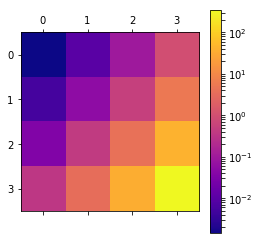

In [186]:
plt.matshow(times1a.mean((-1,-2)), norm=LogNorm(), cmap="plasma")
plt.colorbar()

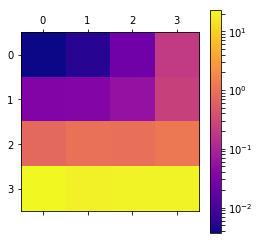

In [184]:
plt.matshow(times2a.mean((-1,-2)), norm=LogNorm(), cmap="plasma")
plt.colorbar()

Text(0,0.5,'Size of point cloud')

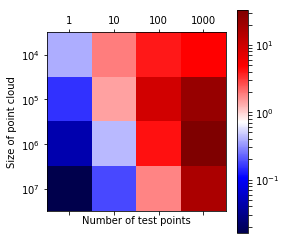

In [205]:
plt.matshow(times1a.mean((-1,-2)) / times2a.mean((-1,-2)), norm=LogNorm(), cmap="seismic")
plt.colorbar()
ax = plt.gca()
ax.set_xticklabels((None, "1", "10", "100", "1000"))
ax.set_yticklabels((None, "$10^4$", "$10^5$", "$10^6$", "$10^7$"))
ax.set_xlabel("Number of test points")
ax.set_ylabel("Size of point cloud")

In [ ]:
a.set_xticklabels()